# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [2]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

Keyring is skipped due to an exception: 'keyring.backends'
  Using cached smdebug-1.0.12-py2.py3-none-any.whl (270 kB)
  Using cached pyinstrument-3.4.2-py2.py3-none-any.whl (83 kB)
  Using cached pyinstrument_cext-0.2.4-cp37-cp37m-manylinux2010_x86_64.whl (20 kB)

[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: pip install --upgrade pip


In [3]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3
import os
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
session = sagemaker.Session()
bucket = session.default_bucket()
role = sagemaker.get_execution_role()
region = "us-east-1"
data = "s3://{}/{}/".format(bucket, "dogBreedClassification/dogImages")
output = "s3://{}/{}/".format(bucket, "dogBreedClassification/output")
model_dir = "s3://{}/{}/".format(bucket, "dogBreedClassification/model")
#initialisation of environ variables
os.environ["DEFAULT_S3_BUCKET"] = bucket
os.environ['SM_CHANNEL_TRAINING']= data 
os.environ['SM_OUTPUT_DATA_DIR']= output
os.environ['SM_MODEL_DIR']= model_dir

#printing the content of bucket, region and role
print("Default Bucket: {}".format(bucket))
print("AWS Region: {}".format(region))
print("RoleArn: {}".format(role))

Default Bucket: sagemaker-us-east-1-680818251749
AWS Region: us-east-1
RoleArn: arn:aws:iam::680818251749:role/service-role/AmazonSageMaker-ExecutionRole-20221214T121315


## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [4]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

--2023-02-08 10:53:34--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.116.176
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.116.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  43.9MB/s    in 25s     

2023-02-08 10:54:08 (42.8 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]

Archive:  dogImages.zip
   creating: dogImages/
   creating: dogImages/test/
   creating: dogImages/train/
   creating: dogImages/valid/
   creating: dogImages/test/001.Affenpinscher/
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg  
  inflating: dogImages/test/001.

In [5]:
#uploading data on s3

!aws s3 sync ./dogImages s3://${DEFAULT_S3_BUCKET}/dogBreedClassification/dogImages/

upload: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg to s3://sagemaker-us-east-1-680818251749/dogBreedClassification/dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg
upload: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg to s3://sagemaker-us-east-1-680818251749/dogBreedClassification/dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg
upload: dogImages/test/001.Affenpinscher/Affenpinscher_00058.jpg to s3://sagemaker-us-east-1-680818251749/dogBreedClassification/dogImages/test/001.Affenpinscher/Affenpinscher_00058.jpg
upload: dogImages/test/001.Affenpinscher/Affenpinscher_00047.jpg to s3://sagemaker-us-east-1-680818251749/dogBreedClassification/dogImages/test/001.Affenpinscher/Affenpinscher_00047.jpg
upload: dogImages/test/001.Affenpinscher/Affenpinscher_00048.jpg to s3://sagemaker-us-east-1-680818251749/dogBreedClassification/dogImages/test/001.Affenpinscher/Affenpinscher_00048.jpg
upload: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg to s3

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [4]:
#TODO: Declare your HP ranges, metrics etc.
import os
os.environ["DEFAULT_S3_BUCKET"]=bucket
from sagemaker.tuner import(IntegerParameter,
                            CategoricalParameter,
                            ContinuousParameter,
                            HyperparameterTuner,
                           )

In [5]:
#TODO: Create estimators for your HPs
#I was inspired by the course code.
from sagemaker.pytorch import PyTorch
estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.m5.large"
)

hyperparameter_ranges={
    "lr": ContinuousParameter(0.001,0.1),
    "batch_size": CategoricalParameter([32,64,128,256,512]),
    "epochs": IntegerParameter(2,4)

}

objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type,
)


In [6]:
# TODO: Fit your HP Tuner
tuner.fit({"training": data})

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [8]:
# TODO: Get the best estimators and the best HPs

best_estimator =tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()




2023-02-09 12:33:46 Starting - Found matching resource for reuse
2023-02-09 12:33:46 Downloading - Downloading input data
2023-02-09 12:33:46 Training - Training image download completed. Training in progress.
2023-02-09 12:33:46 Uploading - Uploading generated training model
2023-02-09 12:33:46 Completed - Resource retained for reuse


{'_tuning_objective_metric': '"average test loss"',
 'batch_size': '"32"',
 'epochs': '4',
 'lr': '0.06271147221173151',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2023-02-09-11-20-18-691"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-680818251749/pytorch-training-2023-02-09-11-20-18-691/source/sourcedir.tar.gz"'}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [9]:
# TODO: Set up debugging and profiling rules and hooks
from sagemaker.debugger import Rule,ProfilerRule, rule_configs
from sagemaker.debugger import (
    DebuggerHookConfig,
    CollectionConfig,
    ProfilerConfig,
    FrameworkProfile
)

rules=[
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

collection_configs=[CollectionConfig(name="CrossEntropyLoss_output_0",parameters={
    "include_regex": "CrossEntropyLoss_output_0", "train.save_interval": "10","eval.save_interval": "1"})]

profiler_config = ProfilerConfig(
    #system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=1)
)
debugger_config=DebuggerHookConfig(
    collection_configs=collection_configs
)

best_hyperparameters={'batch_size': 32,
                      'epochs': 4,
                      'lr': 0.06271147221173151,}


In [13]:
# TODO: Create and fit an estimator

estimator = PyTorch(
    role=sagemaker.get_execution_role(),
    instance_count=1,
    instance_type="ml.g4dn.xlarge", 
    #instance_type="ml.m5.large", #with this instance, the job failed
    entry_point="train_model.py",
    framework_version="1.4.0",
    py_version="py3",
    hyperparameters=best_hyperparameters,
    profiler_config=profiler_config, 
    debugger_hook_config=debugger_config, 
    rules=rules
)

estimator.fit({
    'train' : data
},wait=True)

2023-02-09 13:11:14 Starting - Starting the training job...
2023-02-09 13:11:44 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
.........
2023-02-09 13:13:12 Downloading - Downloading input data......
2023-02-09 13:14:12 Training - Downloading the training image...
2023-02-09 13:14:41 Training - Training image download completed. Training in progress....bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-02-09 13:15:00,166 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2023-02-09 13:15:00,193 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-02-09 13:15:00,196 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-02-09 13:15:00,353 sagemaker-containers INFO     Module default_us

In [15]:
job_name = estimator.latest_training_job.name
sagemaker_client = estimator.sagemaker_session.sagemaker_client
job_description = sagemaker_client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)

In [8]:
print(f"Jobname: {job_name}")
print(f"Client: {sagemaker_client}")
print(f"Description: {job_description}")

Jobname: pytorch-training-2023-02-08-13-07-33-469
Client: <botocore.client.SageMaker object at 0x7fb5a42ea910>
Description: {'TrainingJobName': 'pytorch-training-2023-02-08-13-07-33-469', 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:680818251749:training-job/pytorch-training-2023-02-08-13-07-33-469', 'ModelArtifacts': {'S3ModelArtifacts': 's3://sagemaker-us-east-1-680818251749/pytorch-training-2023-02-08-13-07-33-469/output/model.tar.gz'}, 'TrainingJobStatus': 'Completed', 'SecondaryStatus': 'Completed', 'HyperParameters': {'batch_size': '128', 'epochs': '1', 'lr': '0.0430809134479483', 'sagemaker_container_log_level': '20', 'sagemaker_job_name': '"pytorch-training-2023-02-08-13-07-33-469"', 'sagemaker_program': '"train_model.py"', 'sagemaker_region': '"us-east-1"', 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-680818251749/pytorch-training-2023-02-08-13-07-33-469/source/sourcedir.tar.gz"'}, 'AlgorithmSpecification': {'TrainingImage': '763104351884.dkr.ecr.us-east-1.amazon

In [16]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
#creating a trial
trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2023-02-09 13:25:13.211 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:17 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2023-02-09 13:25:13.225 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:17 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-680818251749/pytorch-training-2023-02-09-13-11-14-392/debug-output
[2023-02-09 13:25:14.305 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:17 WARNING s3handler.py:183] Encountered the exception An error occurred while reading from response stream: ('Connection broken: IncompleteRead(0 bytes read, 214 more expected)', IncompleteRead(0 bytes read, 214 more expected)) while reading s3://sagemaker-us-east-1-680818251749/pytorch-training-2023-02-09-13-11-14-392/debug-output/index/000000000/000000000212_worker_0.json . Will retry now


In [17]:
trial.tensor_names() #all the tensor names

[2023-02-09 13:25:21.234 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:17 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2023-02-09 13:25:22.257 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:17 INFO trial.py:210] Loaded all steps


['CrossEntropyLoss_output_0',
 'gradient/ResNet_fc.0.bias',
 'gradient/ResNet_fc.0.weight',
 'gradient/ResNet_fc.2.bias',
 'gradient/ResNet_fc.2.weight',
 'layer1.0.relu_input_0',
 'layer1.0.relu_input_1',
 'layer1.0.relu_input_2',
 'layer1.1.relu_input_0',
 'layer1.1.relu_input_1',
 'layer1.1.relu_input_2',
 'layer1.2.relu_input_0',
 'layer1.2.relu_input_1',
 'layer1.2.relu_input_2',
 'layer2.0.relu_input_0',
 'layer2.0.relu_input_1',
 'layer2.0.relu_input_2',
 'layer2.1.relu_input_0',
 'layer2.1.relu_input_1',
 'layer2.1.relu_input_2',
 'layer2.2.relu_input_0',
 'layer2.2.relu_input_1',
 'layer2.2.relu_input_2',
 'layer2.3.relu_input_0',
 'layer2.3.relu_input_1',
 'layer2.3.relu_input_2',
 'layer3.0.relu_input_0',
 'layer3.0.relu_input_1',
 'layer3.0.relu_input_2',
 'layer3.1.relu_input_0',
 'layer3.1.relu_input_1',
 'layer3.1.relu_input_2',
 'layer3.2.relu_input_0',
 'layer3.2.relu_input_1',
 'layer3.2.relu_input_2',
 'layer3.3.relu_input_0',
 'layer3.3.relu_input_1',
 'layer3.3.rel

In [25]:
# Now the debugging plot.
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):
    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
Completed TRAIN plot
Completed EVAL plot


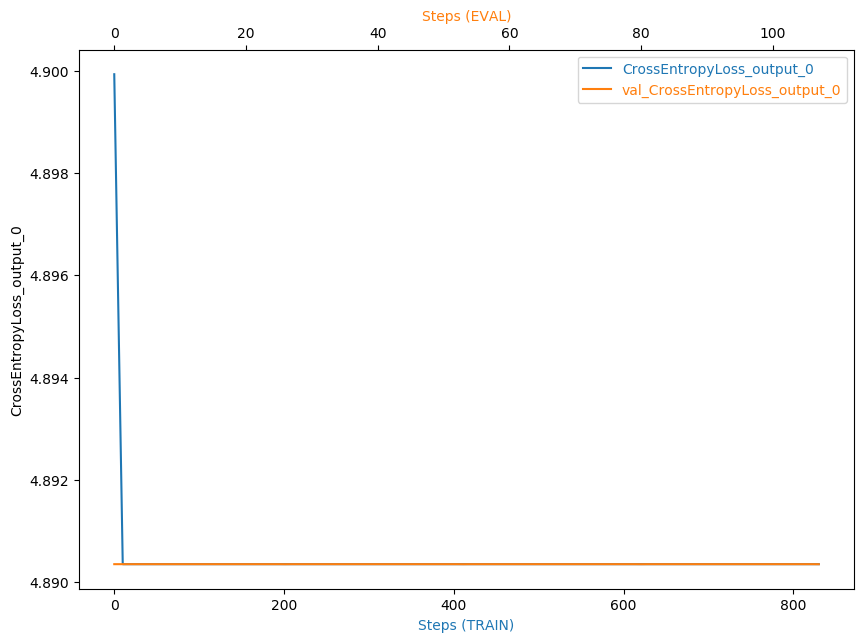

In [21]:
#plotting the tensor
plot_tensor(trial, "CrossEntropyLoss_output_0")

In [ ]:
# TODO: Plot a debugging output.

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [29]:
# TODO: Display the profiler output
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"Profiler report location: {rule_output_path}")

Profiler report location: s3://sagemaker-us-east-1-680818251749/pytorch-training-2023-02-09-13-11-14-392/rule-output


In [30]:
! aws s3 ls {rule_output_path} --recursive

2023-02-09 13:23:01     382930 pytorch-training-2023-02-09-13-11-14-392/rule-output/ProfilerReport/profiler-output/profiler-report.html
2023-02-09 13:23:00     233948 pytorch-training-2023-02-09-13-11-14-392/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2023-02-09 13:22:56        547 pytorch-training-2023-02-09-13-11-14-392/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2023-02-09 13:22:56      16507 pytorch-training-2023-02-09-13-11-14-392/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2023-02-09 13:22:56        126 pytorch-training-2023-02-09-13-11-14-392/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2023-02-09 13:22:56        311 pytorch-training-2023-02-09-13-11-14-392/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2023-02-09 13:22:56       1592 pytorch-training-2023-02-09-13-11-14-392/rule-output/ProfilerReport/profiler-output/profiler-re

In [31]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-680818251749/pytorch-training-2023-02-09-13-11-14-392/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-680818251749/pytorch-training-2023-02-09-13-11-14-392/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-680818251749/pytorch-training-2023-02-09-13-11-14-392/rule-output/ProfilerReport/profiler-output/profiler-report.html to ProfilerReport/profiler-output/profiler-report.html
download: s3://sagemaker-us-east-1-680818251749/pytorch-training-2023-02-09-13-11-14-392/rule-output/ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json to ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json
download: s3://sagemaker-us-east-1-680818251749/pytorch-training-2023-02-09-13-11-14-3

In [32]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [33]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

In [44]:
import shutil
shutil.make_archive("./profiler_report.zip", "zip", "ProfilerReport")

'/root/CD0387-deep-learning-topics-within-computer-vision-nlp-project-starter/profiler_report.zip.zip'

## Model Deploying

In [86]:
# TODO: Deploy your model to an endpoint

predictor=estimator.deploy(initial_instance_count=1, instance_type="ml.m5.xlarge") # TODO: Add your deployment configuration like instance type and number of instances

-----!

In [71]:
print(predictor.endpoint_name)
endpoint=predictor.endpoint_name

pytorch-training-2023-02-09-15-57-38-686


In [81]:
# TODO: Run an prediction on the endpoint

image ="./dogImages/test/004.Akita/Akita_00258.jpg"
with open(image,"rb") as f:
    payload=f.read()
type(payload)

bytes

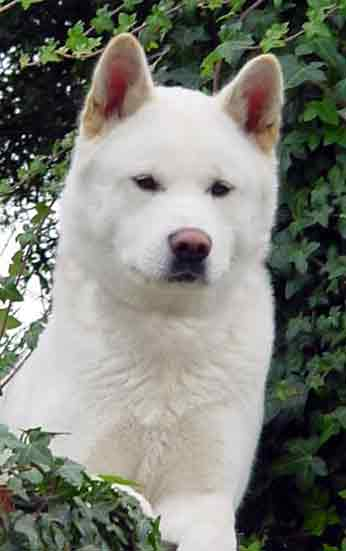

In [82]:
from PIL import Image
import io
Image.open(io.BytesIO(payload))

In [88]:
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor

model_data_artifacts = "s3://sagemaker-us-east-1-680818251749/pytorch-training-2023-02-09-13-11-14-392/output/model.tar.gz"
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()

class ImgPredictor(Predictor):
    def __init__( self, endpoint_name, sagemaker_session):
        super( ImgPredictor, self).__init__(
            endpoint_name,
            sagemaker_session = sagemaker_session,
            serializer = jpeg_serializer,
            deserializer = json_deserializer
        )
        
pytorch_model = PyTorchModel( model_data = model_data_artifacts,
                            role = role,
                             entry_point= "deploy_endpoint.py",
                             py_version = "py36",
                             framework_version = "1.8",
                            predictor_cls = ImgPredictor
                            )

predictor = pytorch_model.deploy( initial_instance_count = 1, instance_type = "ml.m5.large")




------!

In [89]:
response = predictor.predict(payload,initial_args={"ContentType": "image/jpeg"})
print(f"Response: {response}")

Response: [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]


In [90]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()